# 神经网络反向传播 NN Back Propagation

此Notebook是配合Andrew Ng \"Machine Leanring\"中[神经网络](https://github.com/loveunk/machine-learning-deep-learning-notes/blob/master/machine-learning/neural-networks.md)部分学习使用。

测试用python版本为3.6

* 机器学习路径：https://github.com/loveunk/machine-learning-deep-learning-notes/
* 内容正文综合参考网络资源，使用中如果有疑问请联络：www.kaikai.ai

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告

In [14]:
def load_data(path, transpose=True):
    data = sio.loadmat(path)
    y = data.get('y')  # (5000,1)
    y = y.reshape(y.shape[0])

    X = data.get('X')  # (5000,400)

    if transpose:
        X = np.array([im.reshape((20, 20)).T for im in X])
        X = np.array([im.reshape(400) for im in X])

    return X, y

In [15]:
X, _ = load_data('ex4data1.mat')

## 查看数据集（10*10的图像）

In [16]:
def plot_100_image(X):
    """ sample 100 image and show them
    assume the image is square

    X : (5000, 400)
    """
    size = int(np.sqrt(X.shape[1]))

    # sample 100 image, reshape, reorg it
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400
    sample_images = X[sample_idx, :]

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

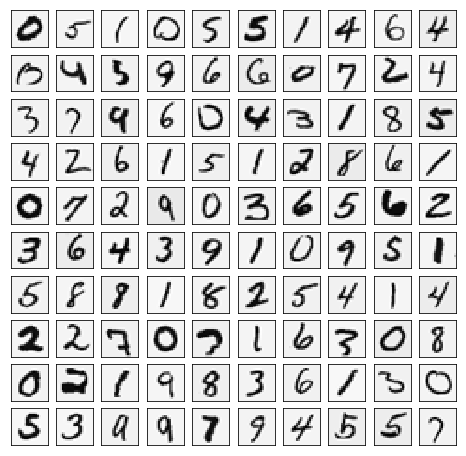

In [17]:
plot_100_image(X)
plt.show()

# 代价函数

In [18]:
X_raw, y_raw = load_data('ex4data1.mat', transpose=False)

# 增加全部为1的一列，
X = np.insert(X_raw, 0, np.ones(X_raw.shape[0]), axis=1)
X.shape

(5000, 401)

In [19]:
y_raw

array([10, 10, 10, ...,  9,  9,  9], dtype=uint8)

In [20]:
def expand_y(y):
#     """expand 5000*1 into 5000*10
#     where y=10 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]: ndarray
#     """
    res = []
    for i in y:
        y_array = np.zeros(10)
        y_array[i - 1] = 1

        res.append(y_array)

    return np.array(res)
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder(sparse=False)
# y_onehot = encoder.fit_transform(y)
# y_onehot.shape #这个函数与expand_y(y)一致

In [21]:
y = expand_y(y_raw)
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

# 读取权重

In [22]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']

In [23]:
t1, t2 = load_weight('ex4weights.mat')
t1.shape, t2.shape

((25, 401), (10, 26))

序列化2矩阵
在这个nn架构中，我们有theta1（25,401），theta2（10,26），它们的梯度是delta1，delta2  

In [24]:
def serialize(a, b):
    return np.concatenate((np.ravel(a), np.ravel(b)))

In [25]:
theta = serialize(t1, t2)  # 扁平化参数，25*401+10*26=10285
theta.shape

(10285,)

# 前向传播 Feedforward
> (400 + 1) -> (25 + 1) -> (10)

<img style="float: center;" src="../img/nn_model.png">

In [26]:
def feed_forward(theta, X):
    """apply to architecture 400+1 * 25+1 *10
    X: 5000 * 401
    """

    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]
    a1 = X  # 5000 * 401

    z2 = a1 @ t1.T  # 5000 * 25
    a2 = np.insert(sigmoid(z2), 0, np.ones(m), axis=1)  # 5000*26

    z3 = a2 @ t2.T  # 5000 * 10
    h = sigmoid(z3)  # 5000*10, this is h_theta(X)

    # return的这些均是后向传播所需要的
    return a1, z2, a2, z3, h

Sigmoid函数的定义为：
$$g(z)={\frac{1}{1+e^{{-z}}}}$$

In [27]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [28]:
def deserialize(seq):
#     """into ndarray of (25, 401), (10, 26)"""
    return seq[:25 * 401].reshape(25, 401), seq[25 * 401:].reshape(10, 26)


In [29]:
_, _, _, _, h = feed_forward(theta, X)
h # 5000*10

array([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
        4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
       [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
        2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
       [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
        6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
       ...,
       [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
        2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
       [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
        1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
       [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
        5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

# 代价函数
先回忆一下，不考虑正则化的代价函数为：
$$J(\Theta)=\frac{1}{m}\sum\limits_{i=1}^m\sum\limits_{k=1}^K{\left[{-y_k^{(i)}}\log\left({h_\Theta}\left({x^{(i)}}\right)\right)_k-\left(1-{y_k^{(i)}}\right)\log\left(1-{h_\theta}\left({x^{(i)}}\right)\right)_k\right]}$$

在这个例子中，$y$ 和 $h_{\theta} \in R^{5000 \times 10}$。

如果忽略m和k维度，代价函数可以写作 $y*log(h_{\theta}) - (1-y)*log(1-h_{\theta})$  
需要做的是把所有维度的代价函数计算后加起来。

In [30]:
def cost(theta, X, y):
    """
    y: (m, k) ndarray
    """
    m = X.shape[0]  # get the data size m

    _, _, _, _, h = feed_forward(theta, X)

    # np.multiply is pairwise operation
    pair_computation = -np.multiply(y, np.log(h)) - np.multiply((1 - y), np.log(1 - h))

    return pair_computation.sum() / m


In [31]:
cost(theta, X, y)

0.2876291651613189

# 正则化代价函数

神经网络正则化的代价函数写作：
\begin{align*}
J(\Theta)=&\frac{1}{m}\sum\limits_{i=1}^m\sum\limits_{k=1}^K{\left[{-y_k^{(i)}}\log\left({h_\Theta}\left({x^{(i)}}\right)\right)_k-\left(1-{y_k^{(i)}}\right)\log\left(1-{h_\theta}\left({x^{(i)}}\right)\right)_k\right]}\\&+\frac{\lambda}{2m}\sum\limits_{l=1}^{L-1}\sum\limits_{i=1}^{s_l}\sum\limits_{j=1}^{s_{l+1}}{\left(\Theta_{ji}^{(l)}\right)^2}
\end{align*}

In [55]:
def regularized_cost(theta, X, y, lambd=1):
    """the first column of t1 and t2 is intercept theta, ignore them when you do regularization"""
    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]

    reg_t1 = (lambd / (2 * m)) * np.power(t1[:, 1:], 2).sum()  # this is how you ignore first col
    reg_t2 = (lambd / (2 * m)) * np.power(t2[:, 1:], 2).sum()

    return cost(theta, X, y) + reg_t1 + reg_t2

In [35]:
regularized_cost(theta, X, y, lambd=1)

0.38376985909092365

# 反向传播 Backpropagation

读取数据和权重过程与前向传播相同

In [36]:
X.shape,y.shape

((5000, 401), (5000, 10))

In [37]:
t1.shape, t2.shape

((25, 401), (10, 26))

In [38]:
theta.shape

(10285,)

## Sigmoid函数梯度
Sigmoid函数梯度函数的公式写作：
$$g'(z) = {\frac{\partial}{\partial z}}g(z)=g(z)(1-g(z))$$

梯度函数的计算函数如下：

In [39]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), 1 - sigmoid(z))

In [40]:
sigmoid_gradient(0)

0.25

# $\Theta$ 的梯度


现在我们准备好实施反向传播来计算梯度。

由于反向传播所需的计算是代价函数中所需的计算过程，我们实际上将扩展代价函数以执行反向传播并返回代价和梯度。
计算的公式如下：
$$\delta^{\left(3\right)}=a^{(3)}-y$$
$$\delta^{\left(2\right)}=\left(Θ^{(2)}\right)^T\delta^{(3)}.*g'(z^{(2)})$$
$$\Delta^{\left(l\right)}=\Delta^{(l)}+\delta^{(l+1)}\left(a^{(l)}\right)^T$$
$$\frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta)=\frac{1}{m}\Delta_{ij}^{l}$$

In [41]:
def gradient(theta, X, y):
    # initialize
    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]

    delta1 = np.zeros(t1.shape)  # (25, 401)
    delta2 = np.zeros(t2.shape)  # (10, 26)

    # 前向传播
    a1, z2, a2, z3, h = feed_forward(theta, X)

    for i in range(m):
        a1i = a1[i, :]  # (1, 401)
        z2i = z2[i, :]  # (1, 25)
        a2i = a2[i, :]  # (1, 26)

        hi = h[i, :]    # (1, 10)
        yi = y[i, :]    # (1, 10)

        # 第3层
        d3i = hi - yi  # (1, 10)

        # 第2层
        z2i = np.insert(z2i, 0, np.ones(1))  # make it (1, 26) to compute d2i
        d2i = np.multiply(t2.T @ d3i, sigmoid_gradient(z2i))  # (1, 26)

        # careful with np vector transpose
        delta2 += np.matrix(d3i).T @ np.matrix(a2i)  # (1, 10).T @ (1, 26) -> (10, 26)
        delta1 += np.matrix(d2i[1:]).T @ np.matrix(a1i)  # (1, 25).T @ (1, 401) -> (25, 401)

    delta1 = delta1 / m
    delta2 = delta2 / m

    return serialize(delta1, delta2)

In [42]:
d1, d2 = deserialize(gradient(theta, X, y))

In [43]:
d1.shape, d2.shape

((25, 401), (10, 26))

# 梯度校验
假设你是用函数$f_{i}(\theta)$计算$\frac{\partial}{\partial\theta_{i}}J(\theta)$，那么可以根据如下公式来判断$f_i$的计算是否准确。

$$f_{i}(\theta)\approx\dfrac{J\left(\theta^{i+}\right)-J\left(\theta^{i-}\right)}{2\varepsilon}$$

梯度检验函数如下：

In [51]:
def gradient_checking(theta, X, y, epsilon, regularized=False):
    def a_numeric_grad(plus, minus, regularized=False):
        """calculate a partial gradient with respect to 1 theta"""
        if regularized:
            return (regularized_cost(plus, X, y) - regularized_cost(minus, X, y)) / (epsilon * 2)
        else:
            return (cost(plus, X, y) - cost(minus, X, y)) / (epsilon * 2)

    theta_matrix = expand_array(theta)  # expand to (10285, 10285)
    epsilon_matrix = np.identity(len(theta)) * epsilon

    plus_matrix = theta_matrix + epsilon_matrix
    minus_matrix = theta_matrix - epsilon_matrix

    # calculate numerical gradient with respect to all theta
    numeric_grad = np.array([a_numeric_grad(plus_matrix[i], minus_matrix[i], regularized)
                                    for i in range(len(theta))])

    # analytical grad will depend on if you want it to be regularized or not
    analytic_grad = regularized_gradient(theta, X, y) if regularized else gradient(theta, X, y)

    # If you have a correct implementation, and assuming you used EPSILON = 0.0001
    # the diff below should be less than 1e-9
    # this is how original matlab code do gradient checking
    diff = np.linalg.norm(numeric_grad - analytic_grad) / np.linalg.norm(numeric_grad + analytic_grad)

    print('如果你的反向传播算法是对的，那么差异会小于 10e-9 (假设 epsilon=0.0001).\n差异为: {}\n'.format(diff))

In [45]:
def expand_array(arr):
    """replicate array into matrix
    [1, 2, 3]

    [[1, 2, 3],
     [1, 2, 3],
     [1, 2, 3]]
    """
    # turn matrix back to ndarray
    return np.array(np.matrix(np.ones(arr.shape[0])).T @ np.matrix(arr))

In [46]:
gradient_checking(theta, X, y, epsilon= 0.0001)#这个运行很慢，谨慎运行

如果你的反向传播算法是对的，那么差异会小于 10e-9 (假设 epsilon=0.0001).
Relative Difference: 2.144837505196823e-09



# 正则化的梯度

我们还需要对反向传播函数进行一个修改，即将梯度计算加正则化。 

\begin{align*}
\frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta)&=\frac{1}{m}\Delta_{ij}^{l} \text{ , for } j = 0\\
\frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta)&=\frac{1}{m}\Delta_{ij}^{l} + \frac{\lambda}{m}\Theta^{(l)}_{ij}\text{ , for } j \ge 1
\end{align*}

最后的正式版本如下。

In [53]:
def regularized_gradient(theta, X, y, l=1):
    """don't regularize theta of bias terms"""
    m = X.shape[0]
    delta1, delta2 = deserialize(gradient(theta, X, y))
    t1, t2 = deserialize(theta)

    t1[:, 0] = 0
    reg_term_d1 = (l / m) * t1
    delta1 = delta1 + reg_term_d1

    t2[:, 0] = 0
    reg_term_d2 = (l / m) * t2
    delta2 = delta2 + reg_term_d2

    return serialize(delta1, delta2)

In [56]:
# 运行耗时，耐心等待
gradient_checking(theta, X, y, epsilon=0.0001, regularized=True)

如果你的反向传播算法是对的，那么差异会小于 10e-9 (假设 epsilon=0.0001).
差异为: 3.188645959632846e-09



# 训练模型

记得随机初始化参数以打破对称性。

In [57]:
def random_init(size):
    return np.random.uniform(-0.12, 0.12, size)

In [58]:
def nn_training(X, y):

    init_theta = random_init(10285)  # 25*401 + 10*26

    res = opt.minimize(fun=regularized_cost,
                       x0=init_theta,
                       args=(X, y, 1),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'maxiter': 400})
    return res

In [92]:
# 运行耗时，耐心等待
res = nn_training(X, y)
res

     fun: 0.3153887919013315
     jac: array([-1.65164486e-04,  4.04632393e-08,  9.52229821e-08, ...,
       -3.20925145e-05, -8.30450522e-05, -8.86181724e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 400
     nit: 27
  status: 3
 success: False
       x: array([ 0.00000000e+00,  2.02316196e-04,  4.76114911e-04, ...,
       -1.07493708e+00,  1.36602285e+00,  6.60932712e-01])

# 显示准确率

In [90]:
_, y_answer = load_data('ex4data1.mat')

In [93]:
final_theta = res.x

In [94]:
def show_accuracy(theta, X, y):
    _, _, _, _, h = feed_forward(theta, X)

    y_pred = np.argmax(h, axis=1) + 1

    print(classification_report(y, y_pred))
    
    correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
    accuracy = (sum(map(int, correct)) / float(len(correct)))
    print ('总体正确率为：{0}%'.format(accuracy * 100))

In [95]:
show_accuracy(final_theta, X, y_answer)

              precision    recall  f1-score   support

           1       0.99      0.97      0.98       500
           2       0.96      0.97      0.97       500
           3       0.95      0.98      0.97       500
           4       0.94      0.99      0.96       500
           5       1.00      0.92      0.95       500
           6       0.93      1.00      0.96       500
           7       0.99      0.93      0.96       500
           8       0.98      0.97      0.97       500
           9       1.00      0.89      0.94       500
          10       0.90      1.00      0.95       500

   micro avg       0.96      0.96      0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000

总体正确率为：96.14%


# 显示隐藏层

In [96]:
def plot_hidden_layer(theta):
    """
    theta: (10285, )
    """
    final_theta1, _ = deserialize(theta)
    hidden_layer = final_theta1[:, 1:]  # ger rid of bias term theta

    fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(5, 5))

    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(hidden_layer[5 * r + c].reshape((20, 20)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

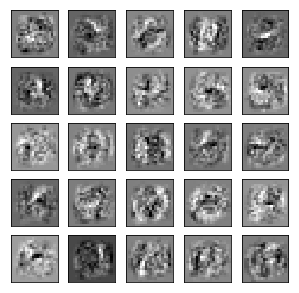

In [97]:
plot_hidden_layer(final_theta)
plt.show()